In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

#importing helper functions for pre-processing data
from util import cleaning_data, stemming, wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oleksandrafilippova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# cleanine_data function loads in data, adds labels, removes all punctuation & stop words 
data = cleaning_data("data/true.csv", "data/fake.csv")

/Users/oleksandrafilippova/ML_class/final_project/nlp_project_yas/util.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = true_df.append(fake_df).sample(frac=1).reset_index().drop(columns=['index'])


Example of the dataset `data` consisting of both labels(1 is True, 0 is Fake):

In [36]:
data

,text,target
0,huge news head coach university michigan footb...,0
1,white house said monday sought reassure china ...,1
2,house democrats introduced legislation wednesd...,1
3,first public campaigns ahead australia vote le...,1
4,michael cohen one president donald trump close...,1
...,...,...
44893,president barack obama foreign policy legacy r...,1
44894,obama released statement position regarding is...,0
44895,robert de niro supposed appear non partisan pu...,0
44896,president trump told reporters friday democrat...,1


In [37]:
print('distribution of word frequencies before stemming: ')
pd.Series(' '.join(data['text']).split()).value_counts().describe()

distribution of word frequencies before stemming: 


count    121766.000000
mean         87.001774
std         879.965508
min           1.000000
25%           1.000000
50%           2.000000
75%          11.000000
max      133992.000000
dtype: float64

In [38]:
print('top 10 words before stemming are: ')
pd.Series(' '.join(data['text']).split()).value_counts()[:10]

top 10 words before stemming are: 


trump        133992
said         132816
president     55890
would         55165
people        41855
one           37892
state         34486
also          31357
new           30310
clinton       28694
dtype: int64

Cloud of words for the entire dataset:


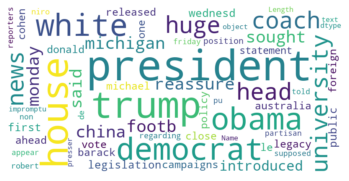

Cloud of words for false articles:


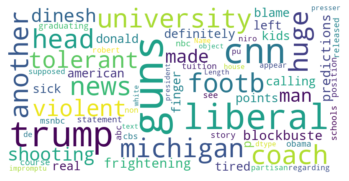

Cloud of words for true articles:


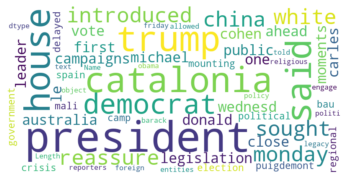

In [39]:
%matplotlib inline
print('Cloud of words for the entire dataset:')
wordcloud(data.text, 100)

print('Cloud of words for false articles:')
wordcloud(data[data.target == 0].text, 100)

print('Cloud of words for true articles:')
wordcloud(data[data.target == 1].text, 100)

## From the descriptive statistics above: 

- The dataset consists `121,766` unique words after stop words (i.e., *you*, *she*, *and*).
- The median frequency among all words equals to `2`. Meaning, at least a half of all words were mentioned once or twice in the entire dataset.
- The word that was mentioned the most is `Trump`. It was mentioned `133,992` times. 

Having `121,766` features for a `40,000`-observation dataset we are risking to encounter **Curse of Dimensionality**. We need to reduce the number of total features before training the model.

In [40]:
data['text'] = stemming(data['text'])

In [42]:
print('distribution of stems frequencies after stemming: ')
pd.Series(' '.join(data['text']).split()).value_counts().describe()

distribution of stems frequencies after stemming: 


count     95924.000000
mean        110.440119
std        1126.504906
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
max      134244.000000
dtype: float64

In [43]:
print('top 10 stems after stemming are: ')
pd.Series(' '.join(data['text']).split()).value_counts()[:10]

top 10 stems after stemming are: 


trump         134244
said          132816
state          63382
presid         60429
would          55165
peopl          42011
year           41759
republican     39743
one            39104
say            36911
dtype: int64

## From the descriptive statistics above (after stemming): 

- The dataset consists `95,924` unique tokens (stems). By stemming we were able to eliminate ~25,000 features.
- The median frequency among all tokens equals to `2`. Meaning, at least a half of all words were mentioned once or twice in the entire dataset. 
- Like in the distribution before stemming, the word that was mentioned the most is `Trump`. It was mentioned `134,244` times. 

This is still a high number of potential features. We may need to reduce it more.

In [44]:
# Split the data into two parts: training data (7/10) and other data (3/10)
train_text, val_test_text = train_test_split(data, random_state=1234, test_size=0.3, stratify=data['target'])

# Split other data into two parts: validation data (1/3 * 3/10 = 1/10) and testing data (2/3 * 3/10 = 2/10)
val_text, test_text = train_test_split(val_test_text, random_state=1234, test_size=0.6, stratify=val_test_text['target'])

Example of the `train_text` data frame:

In [45]:
train_text

,text,target
22196,daimler ag merced benz usa daimler van unit fe...,1
29546,donald trump might want stop creat public poll...,0
15951,rememb promis fenc southern border yes plan 2 ...,0
21204,presid barack obama travel orlando florida thu...,1
12397,wife oust pakistani prime minist nawaz sharif ...,1
...,...,...
11174,shawn helton 21st centuri wireanti trump stree...,0
2952,megyn kelli may depart fox news legitim pastur...,0
40272,presid donald trump like face question execut ...,1
33571,sinc presid obama took offic 2009 right wing a...,0


For our baseline model, we will be using the `TF-IDF` Vectorizer to pre-process articles and then apply Logistic Classifier.

- **fit_transform()** method learns vocabulary and `IDF` used for both training & test data. Returns document-term matrix with calculated `TF-IDF` values.

- **transform()** method uses the vocabulary and document frequencies (df) learned by **fit_transform()**. Returns document-term matrix with calculated `TF-IDF` values.

In [46]:
# Note, ngrams = 1, which is the default value if not specified in TfidfVectorizer. 
text_transformer = TfidfVectorizer(stop_words='english', max_features=1000)

# vectorize train and test data. Produce TF-IDF for train data
X_train_text = text_transformer.fit_transform(train_text['text'])
X_val_text = text_transformer.transform(val_text['text'])
X_test_text = text_transformer.transform(test_text['text'])

Below is the example of 100 features to be used in the model: 

In [47]:
feature_names = text_transformer.get_feature_names_out()
feature_names[:100]

array(['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18',
       '20', '2012', '2013', '2014', '2015', '2016', '2017', '21st',
       '21wire', '24', '25', '30', '50', 'abl', 'abort', 'absolut',
       'abus', 'accept', 'access', 'accord', 'account', 'accus', 'act',
       'action', 'activ', 'activist', 'actual', 'ad', 'addit', 'address',
       'administr', 'admit', 'advanc', 'advis', 'affair', 'affect',
       'afford', 'african', 'agenc', 'agenda', 'agent', 'ago', 'agre',
       'agreement', 'ahead', 'aid', 'aim', 'air', 'al', 'alleg', 'alli',
       'allow', 'alreadi', 'alway', 'ambassador', 'amend', 'america',
       'american', 'announc', 'anoth', 'answer', 'anti', 'anyon', 'anyth',
       'appar', 'appeal', 'appear', 'appoint', 'approach', 'approv',
       'april', 'arabia', 'area', 'argu', 'arm', 'armi', 'arrest',
       'arriv', 'articl', 'ask', 'assault', 'assist', 'associ', 'attack',
       'attempt', 'attend', 'attorney', 'august', 'author'], dtype=object)

In [48]:
print('The number of observations (articles) in  the train data: ', X_train_text.shape[0])
print('The number of features (tokens) in  the train data: ', X_train_text.shape[1])

The number of observations (articles) in  the train data:  31428
The number of features (tokens) in  the train data:  1000


Example of `TF-IDF` matrix, **val_text**, for the validation dataset:

In [49]:
X_val_text.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.0711436 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.09220663, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

We will be using the `Logistic Classifier` as our baseline model for training:

In [50]:
logit = LogisticRegression(penalty = 'l2', C = 1, solver= 'sag', multi_class = 'multinomial')
logit.fit(X_train_text, train_text['target'])

LogisticRegression(C=1, multi_class='multinomial', solver='sag')

Now that we have trained our model, we will apply it to predict labels (true/false) for articles in the test data and calculate the accuracy score:

In [51]:
train_predicted_label = logit.predict(X_train_text)
train_accuracy_score = accuracy_score(train_text['target'], train_predicted_label)

predicted_label = logit.predict(X_val_text)
accuracy_score = accuracy_score(val_text['target'], predicted_label)

print('the accuracy score on the training data is: ', train_accuracy_score)
print('the accuracy score on the validation data is: ', accuracy_score)

the accuracy score on the training data is:  0.9755631920580374
the accuracy score on the validation data is:  0.9730883444691908


**Future steps:**

- Continue cleaning data with the use of Regex and other packages (digits, punctation, 'Router', '21st century')

- Further analysis of data

- Re-run model after data is cleaned

- Discover options to improve the model

Notes form meeting with Cole:

try different models with different # number of features 

1. spacy for steming/punctation - `done`
2. remove article sources - `done`
3. try different # of features - `pending`

analysis: size of trainings 
distribution of words 